# Chapter 6: Decision Trees - Comprehensive Guide

## Overview
Decision Trees are versatile Machine Learning algorithms that can perform both **classification** and **regression** tasks, and even **multioutput** tasks. They are powerful algorithms capable of fitting complex datasets and serve as fundamental components of Random Forests.

### Key Characteristics:
- **White box models**: Easy to interpret and understand
- **No data preparation needed**: No feature scaling or centering required
- **Versatile**: Can handle both numerical and categorical features
- **Prone to overfitting**: Especially without proper regularization

### Learning Objectives:
1. Understand how Decision Trees make predictions
2. Learn the CART training algorithm
3. Master regularization techniques
4. Implement both classification and regression trees
5. Understand limitations and instability issues

## Setup and Imports
Let's start by importing all necessary libraries and setting up our environment.

In [8]:
# Install required packages for Google Colab
!pip install graphviz
!apt-get install graphviz

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, make_moons, make_classification
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
import graphviz
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Setup complete!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Setup complete!


## Part 1: Training and Visualizing Decision Trees

### Theory: How Decision Trees Work

A Decision Tree makes predictions by asking a series of binary questions about the features. Starting from the root node, it navigates down the tree based on the answers until it reaches a leaf node, which provides the final prediction.

### Mathematical Foundation

#### Gini Impurity
The Gini impurity measures how "pure" a node is. For the i-th node:

$$G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$$

Where:
- $p_{i,k}$ is the ratio of class k instances among the training instances in the i-th node
- $G_i = 0$ means the node is pure (all instances belong to the same class)
- $G_i$ is maximum when classes are equally distributed

#### Entropy
Alternative impurity measure:

$$H_i = -\sum_{k=1, p_{i,k} \neq 0}^{n} p_{i,k} \log_2(p_{i,k})$$

Let's implement and visualize these concepts:

In [9]:
# Load the iris dataset
iris = load_iris()
X = iris.data[:, 2:]  # Use only petal length and width for visualization
y = iris.target

print("Dataset shape:", X.shape)
print("Features:", iris.feature_names[2:])
print("Classes:", iris.target_names)
print("\nFirst 5 samples:")
print(X[:5])
print("First 5 labels:", y[:5])

Dataset shape: (150, 2)
Features: ['petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']

First 5 samples:
[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]
First 5 labels: [0 0 0 0 0]


In [10]:
# Train a Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

print("Decision Tree trained successfully!")
print(f"Tree depth: {tree_clf.get_depth()}")
print(f"Number of leaves: {tree_clf.get_n_leaves()}")

Decision Tree trained successfully!
Tree depth: 2
Number of leaves: 3


### Tree Visualization and Interpretation

Each node in the tree contains important information:
- **samples**: Number of training instances that reach this node
- **value**: Number of training instances of each class in this node
- **gini**: Gini impurity of the node
- **class**: The predicted class (majority class in the node)

Let's visualize our trained tree:

In [11]:
# Create a text representation of the tree
from sklearn.tree import export_text

tree_rules = export_text(tree_clf,
                        feature_names=iris.feature_names[2:],
                        class_names=list(iris.target_names))
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- petal length (cm) <= 2.45
|   |--- class: setosa
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- class: versicolor
|   |--- petal width (cm) >  1.75
|   |   |--- class: virginica



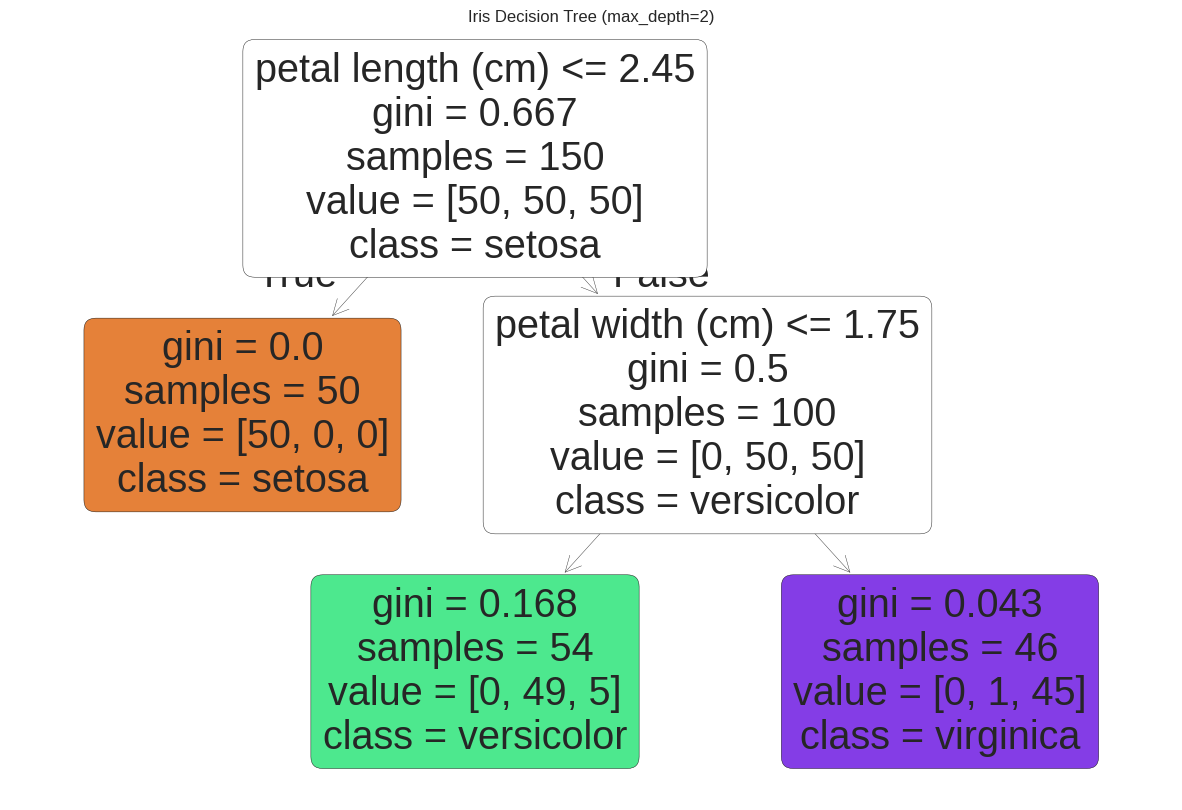


Node Analysis:
Root node (all samples):
Samples per class: [50, 50, 50]
Proportions: ['0.333', '0.333', '0.333']
Gini impurity: 1 - 0.333² - 0.333² - 0.333² = 0.667

Left child (setosa):
Samples per class: [50, 0, 0]
Proportions: ['1.000', '0.000', '0.000']
Gini impurity: 1 - 1.000² - 0.000² - 0.000² = 0.000

Right child (mixed):
Samples per class: [0, 50, 50]
Proportions: ['0.000', '0.500', '0.500']
Gini impurity: 1 - 0.000² - 0.500² - 0.500² = 0.500


0.5

In [12]:
# Create a visual representation
plt.figure(figsize=(15, 10))
plot_tree(tree_clf,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          filled=True,
          rounded=True)
plt.title("Iris Decision Tree (max_depth=2)")
plt.show()

# Let's also create a more detailed analysis of each node
def analyze_node_impurity(samples_per_class):
    """Calculate and explain Gini impurity for a node"""
    total = sum(samples_per_class)
    if total == 0:
        return 0

    proportions = [count/total for count in samples_per_class]
    gini = 1 - sum(p**2 for p in proportions)

    print(f"Samples per class: {samples_per_class}")
    print(f"Proportions: {[f'{p:.3f}' for p in proportions]}")
    print(f"Gini impurity: 1 - {' - '.join([f'{p:.3f}²' for p in proportions])} = {gini:.3f}")
    return gini

print("\nNode Analysis:")
print("Root node (all samples):")
analyze_node_impurity([50, 50, 50])
print("\nLeft child (setosa):")
analyze_node_impurity([50, 0, 0])
print("\nRight child (mixed):")
analyze_node_impurity([0, 50, 50])

## Part 2: Making Predictions and Understanding Decision Boundaries

### How Predictions Work

1. **Start at root**: Begin with the top node
2. **Follow path**: Answer binary questions at each node
3. **Reach leaf**: Stop at a leaf node
4. **Make prediction**: Use the majority class in that leaf

### Decision Boundaries
Decision Trees create **orthogonal decision boundaries** (perpendicular to axes), which can be both a strength and limitation.

In [13]:
# Let's make some predictions and trace the decision path
def trace_prediction(tree, X_sample, feature_names, class_names):
    """Trace how a prediction is made through the tree"""
    # Get the decision path
    leaf_id = tree.decision_path(X_sample.reshape(1, -1).astype(np.float32)).toarray()[0]

    print(f"Predicting for sample: {X_sample}")
    print(f"Feature names: {feature_names}")
    print("\nDecision path:")

    for node_id in range(len(leaf_id)):
        if leaf_id[node_id] == 1:  # Node is in the path
            if tree.children_left[node_id] != tree.children_right[node_id]:  # Not a leaf
                threshold = tree.threshold[node_id]
                feature = tree.feature[node_id]
                feature_name = feature_names[feature]
                feature_value = X_sample[feature]

                if feature_value <= threshold:
                    direction = "≤"
                    next_node = "left"
                else:
                    direction = ">"
                    next_node = "right"

                print(f"Node {node_id}: {feature_name} = {feature_value:.3f} {direction} {threshold:.3f} → go {next_node}")
            else:  # Leaf node
                values = tree.value[node_id][0]
                predicted_class = np.argmax(values)
                class_name = class_names[predicted_class]
                probabilities = values / np.sum(values)

                print(f"Leaf {node_id}: Prediction = {class_name}")
                print(f"Class probabilities: {dict(zip(class_names, probabilities))}")

# Test with different samples
test_samples = [
    [1.0, 0.5],  # Should be setosa
    [4.0, 1.2],  # Should be versicolor
    [6.0, 2.0]   # Should be virginica
]

for i, sample in enumerate(test_samples):
    print(f"\n{'='*50}")
    print(f"Example {i+1}:")
    trace_prediction(tree_clf.tree_, np.array(sample),
                    iris.feature_names[2:], iris.target_names)

    # Verify with scikit-learn
    prediction = tree_clf.predict([sample])[0]
    probabilities = tree_clf.predict_proba([sample])[0]
    print(f"\nScikit-learn prediction: {iris.target_names[prediction]}")
    print(f"Probabilities: {dict(zip(iris.target_names, probabilities))}")


Example 1:
Predicting for sample: [1.  0.5]
Feature names: ['petal length (cm)', 'petal width (cm)']

Decision path:
Node 0: petal length (cm) = 1.000 ≤ 2.450 → go left
Leaf 1: Prediction = setosa
Class probabilities: {np.str_('setosa'): np.float64(1.0), np.str_('versicolor'): np.float64(0.0), np.str_('virginica'): np.float64(0.0)}

Scikit-learn prediction: setosa
Probabilities: {np.str_('setosa'): np.float64(1.0), np.str_('versicolor'): np.float64(0.0), np.str_('virginica'): np.float64(0.0)}

Example 2:
Predicting for sample: [4.  1.2]
Feature names: ['petal length (cm)', 'petal width (cm)']

Decision path:
Node 0: petal length (cm) = 4.000 > 2.450 → go right
Node 2: petal width (cm) = 1.200 ≤ 1.750 → go left
Leaf 3: Prediction = versicolor
Class probabilities: {np.str_('setosa'): np.float64(0.0), np.str_('versicolor'): np.float64(0.9074074074074074), np.str_('virginica'): np.float64(0.09259259259259259)}

Scikit-learn prediction: versicolor
Probabilities: {np.str_('setosa'): np.floa

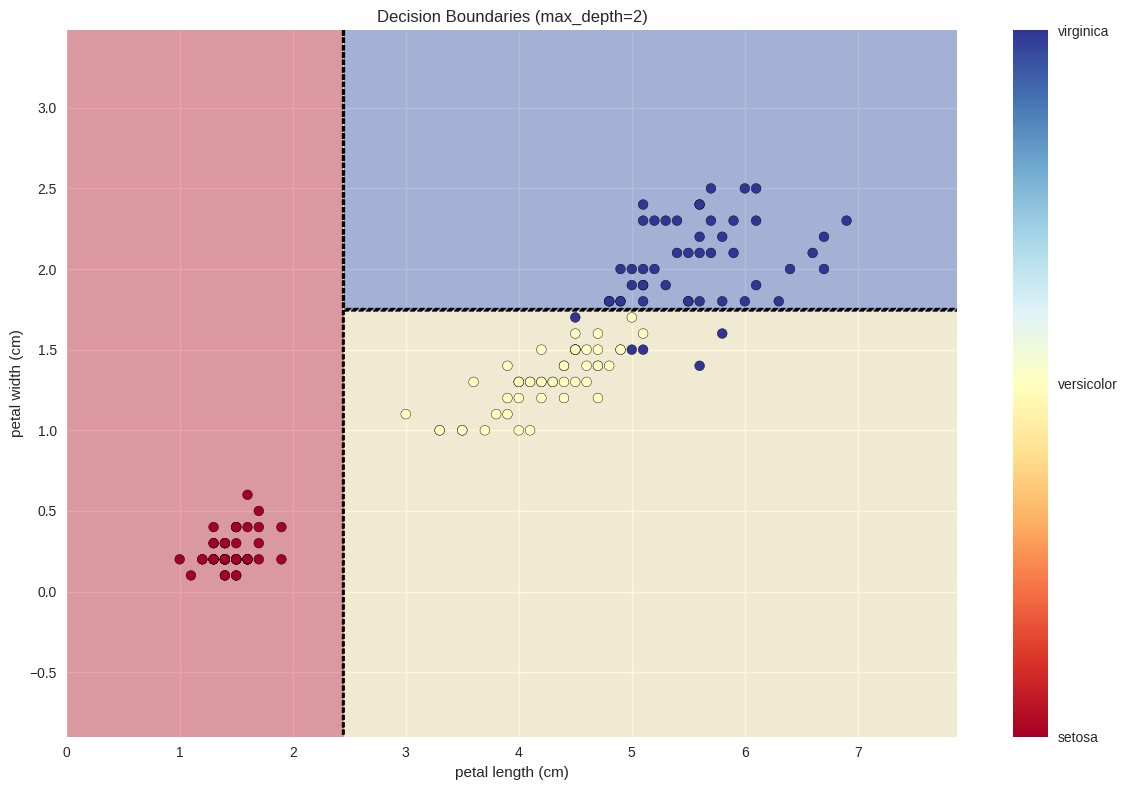

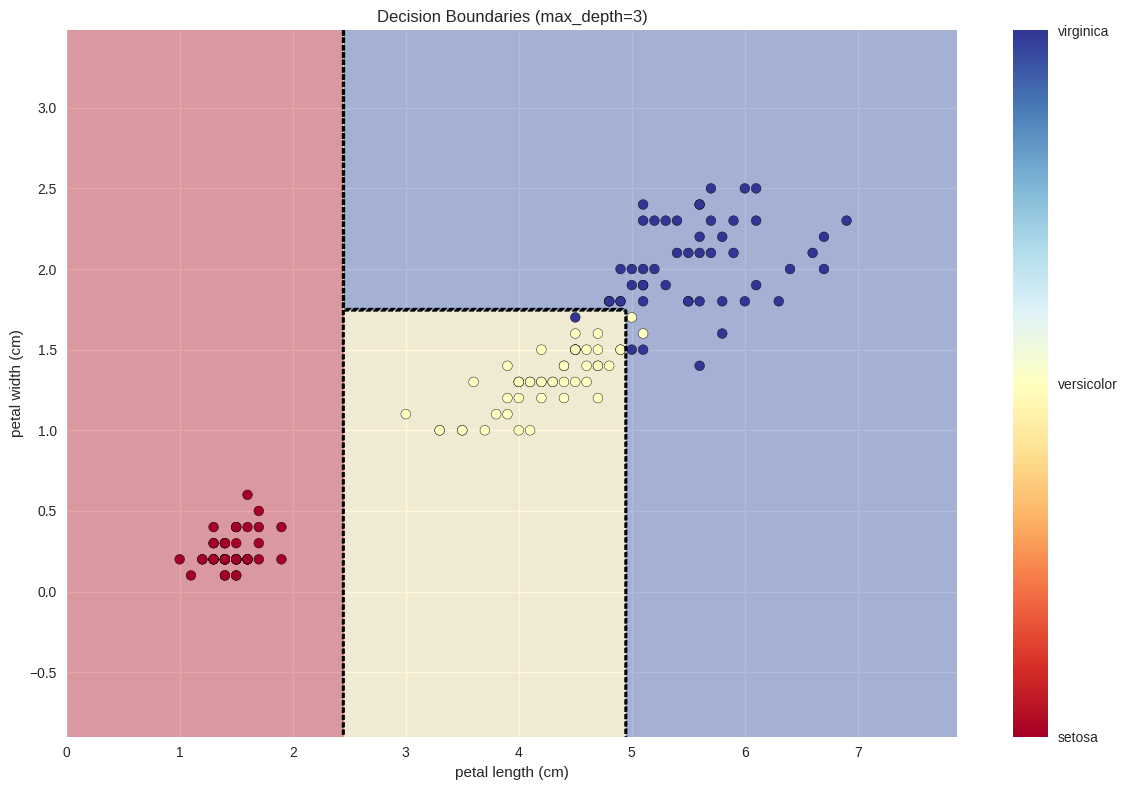

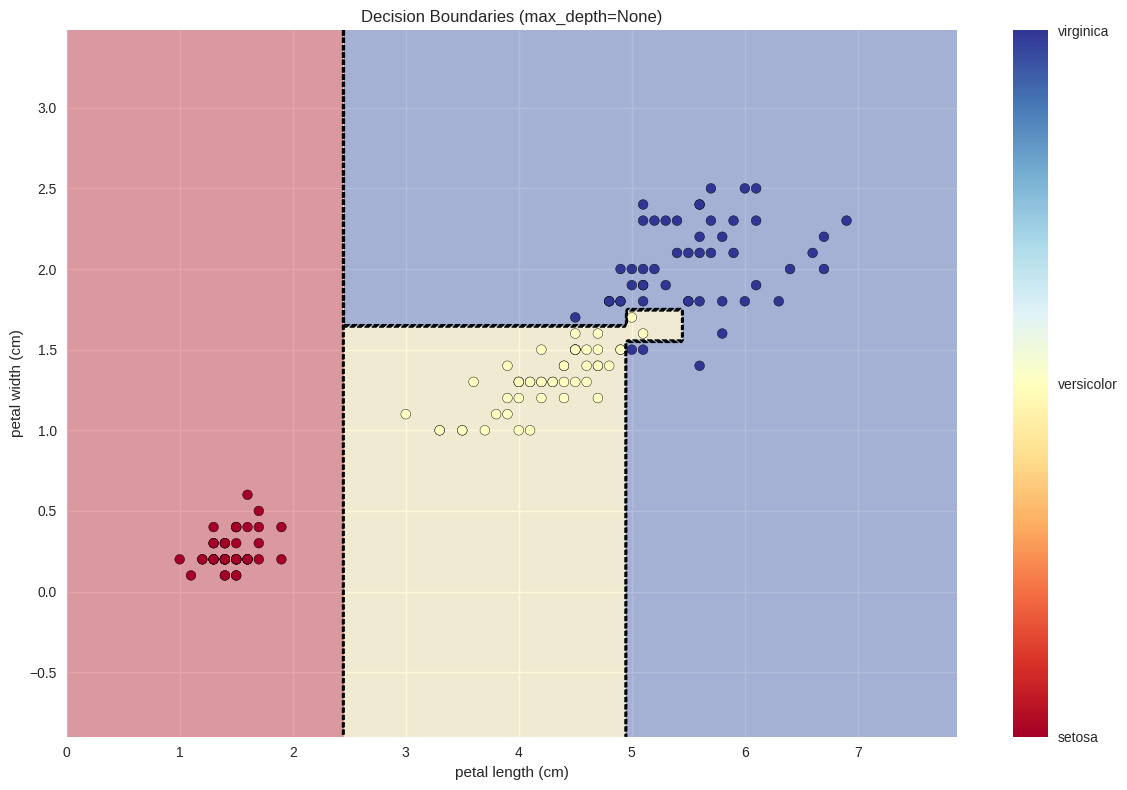

In [14]:
# Visualize decision boundaries
def plot_decision_boundaries(clf, X, y, feature_names, class_names, title=""):
    """Plot decision boundaries for a 2D dataset"""
    h = 0.02  # Step size in the mesh

    # Create a mesh to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Make predictions on the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(12, 8))

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')

    # Add decision boundary lines
    plt.contour(xx, yy, Z, colors='black', linestyles='--', linewidths=1)

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(class_names)

    plt.tight_layout()
    plt.show()

# Plot for different max_depth values
depths = [2, 3, None]
for depth in depths:
    tree_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_temp.fit(X, y)

    title = f"Decision Boundaries (max_depth={depth if depth else 'None'})"
    plot_decision_boundaries(tree_temp, X, y,
                           iris.feature_names[2:], iris.target_names, title)

## Part 3: The CART Training Algorithm

### Theory: Classification and Regression Tree (CART)

CART is a **greedy algorithm** that builds the tree top-down by finding the best split at each node.

#### Algorithm Steps:
1. **Find best split**: Search for the pair (k, t_k) that produces the purest subsets
2. **Split the node**: Divide data based on feature k and threshold t_k  
3. **Recurse**: Repeat the process for each child node
4. **Stop**: When stopping criteria are met

#### Cost Function for Classification:
$$J(k, t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}$$

Where:
- $G_{left/right}$ measures impurity of left/right subset
- $m_{left/right}$ is number of instances in left/right subset
- $m$ is total number of instances

#### Computational Complexity:
- **Training**: O(n × m log(m)) - comparing all features on all samples
- **Prediction**: O(log₂(m)) - traversing balanced tree

Let's implement and demonstrate these concepts:

In [15]:
# Compare Gini impurity vs Entropy
def calculate_gini(y):
    """Calculate Gini impurity"""
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

def calculate_entropy(y):
    """Calculate entropy"""
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    # Avoid log(0)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Create test scenarios with different class distributions
scenarios = {
    "Pure (all class 0)": [0, 0, 0, 0, 0],
    "Pure (all class 1)": [1, 1, 1, 1, 1],
    "Balanced (2 classes)": [0, 0, 0, 1, 1, 1],
    "Imbalanced (2 classes)": [0, 0, 0, 0, 1],
    "Balanced (3 classes)": [0, 0, 1, 1, 2, 2],
    "Mixed (3 classes)": [0, 0, 0, 1, 1, 2]
}

print("Impurity Comparison: Gini vs Entropy")
print("=" * 50)
print(f"{'Scenario':<25} {'Gini':<10} {'Entropy':<10} {'Difference':<10}")
print("-" * 50)

for scenario, y_vals in scenarios.items():
    gini = calculate_gini(y_vals)
    entropy = calculate_entropy(y_vals)
    diff = abs(gini - entropy)

    print(f"{scenario:<25} {gini:<10.3f} {entropy:<10.3f} {diff:<10.3f}")

# Train trees with different criteria
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

tree_gini.fit(X, y)
tree_entropy.fit(X, y)

print("\nTree Comparison:")
print(f"Gini tree - Depth: {tree_gini.get_depth()}, Leaves: {tree_gini.get_n_leaves()}")
print(f"Entropy tree - Depth: {tree_entropy.get_depth()}, Leaves: {tree_entropy.get_n_leaves()}")
print(f"Gini accuracy: {tree_gini.score(X, y):.3f}")
print(f"Entropy accuracy: {tree_entropy.score(X, y):.3f}")

Impurity Comparison: Gini vs Entropy
Scenario                  Gini       Entropy    Difference
--------------------------------------------------
Pure (all class 0)        0.000      -0.000     0.000     
Pure (all class 1)        0.000      -0.000     0.000     
Balanced (2 classes)      0.500      1.000      0.500     
Imbalanced (2 classes)    0.320      0.722      0.402     
Balanced (3 classes)      0.667      1.585      0.918     
Mixed (3 classes)         0.611      1.459      0.848     

Tree Comparison:
Gini tree - Depth: 3, Leaves: 5
Entropy tree - Depth: 3, Leaves: 5
Gini accuracy: 0.973
Entropy accuracy: 0.973


## Part 4: Regularization Hyperparameters

### Theory: Controlling Overfitting

Decision Trees are **nonparametric models** - they can adapt to training data very closely, leading to overfitting. Regularization helps by constraining the tree's freedom.

#### Key Hyperparameters:

1. **max_depth**: Maximum depth of the tree
2. **min_samples_split**: Minimum samples required to split a node
3. **min_samples_leaf**: Minimum samples required in a leaf node
4. **max_leaf_nodes**: Maximum number of leaf nodes
5. **max_features**: Maximum features to consider for splitting
6. **min_weight_fraction_leaf**: Minimum weighted fraction in a leaf

#### Rule of thumb:
- **Increase min_*** → more regularization
- **Decrease max_*** → more regularization

Let's demonstrate overfitting and regularization:

Regularization Impact on Performance:
               Model  Train Accuracy  Test Accuracy  Overfitting  Depth  Leaves
     No restrictions           1.000          0.833        0.167     11      16
         max_depth=3           0.900          0.850        0.050      3       6
 min_samples_leaf=10           0.843          0.783        0.060      6      10
min_samples_split=20           0.914          0.867        0.048      5       8
   max_leaf_nodes=10           0.950          0.867        0.083      7      10


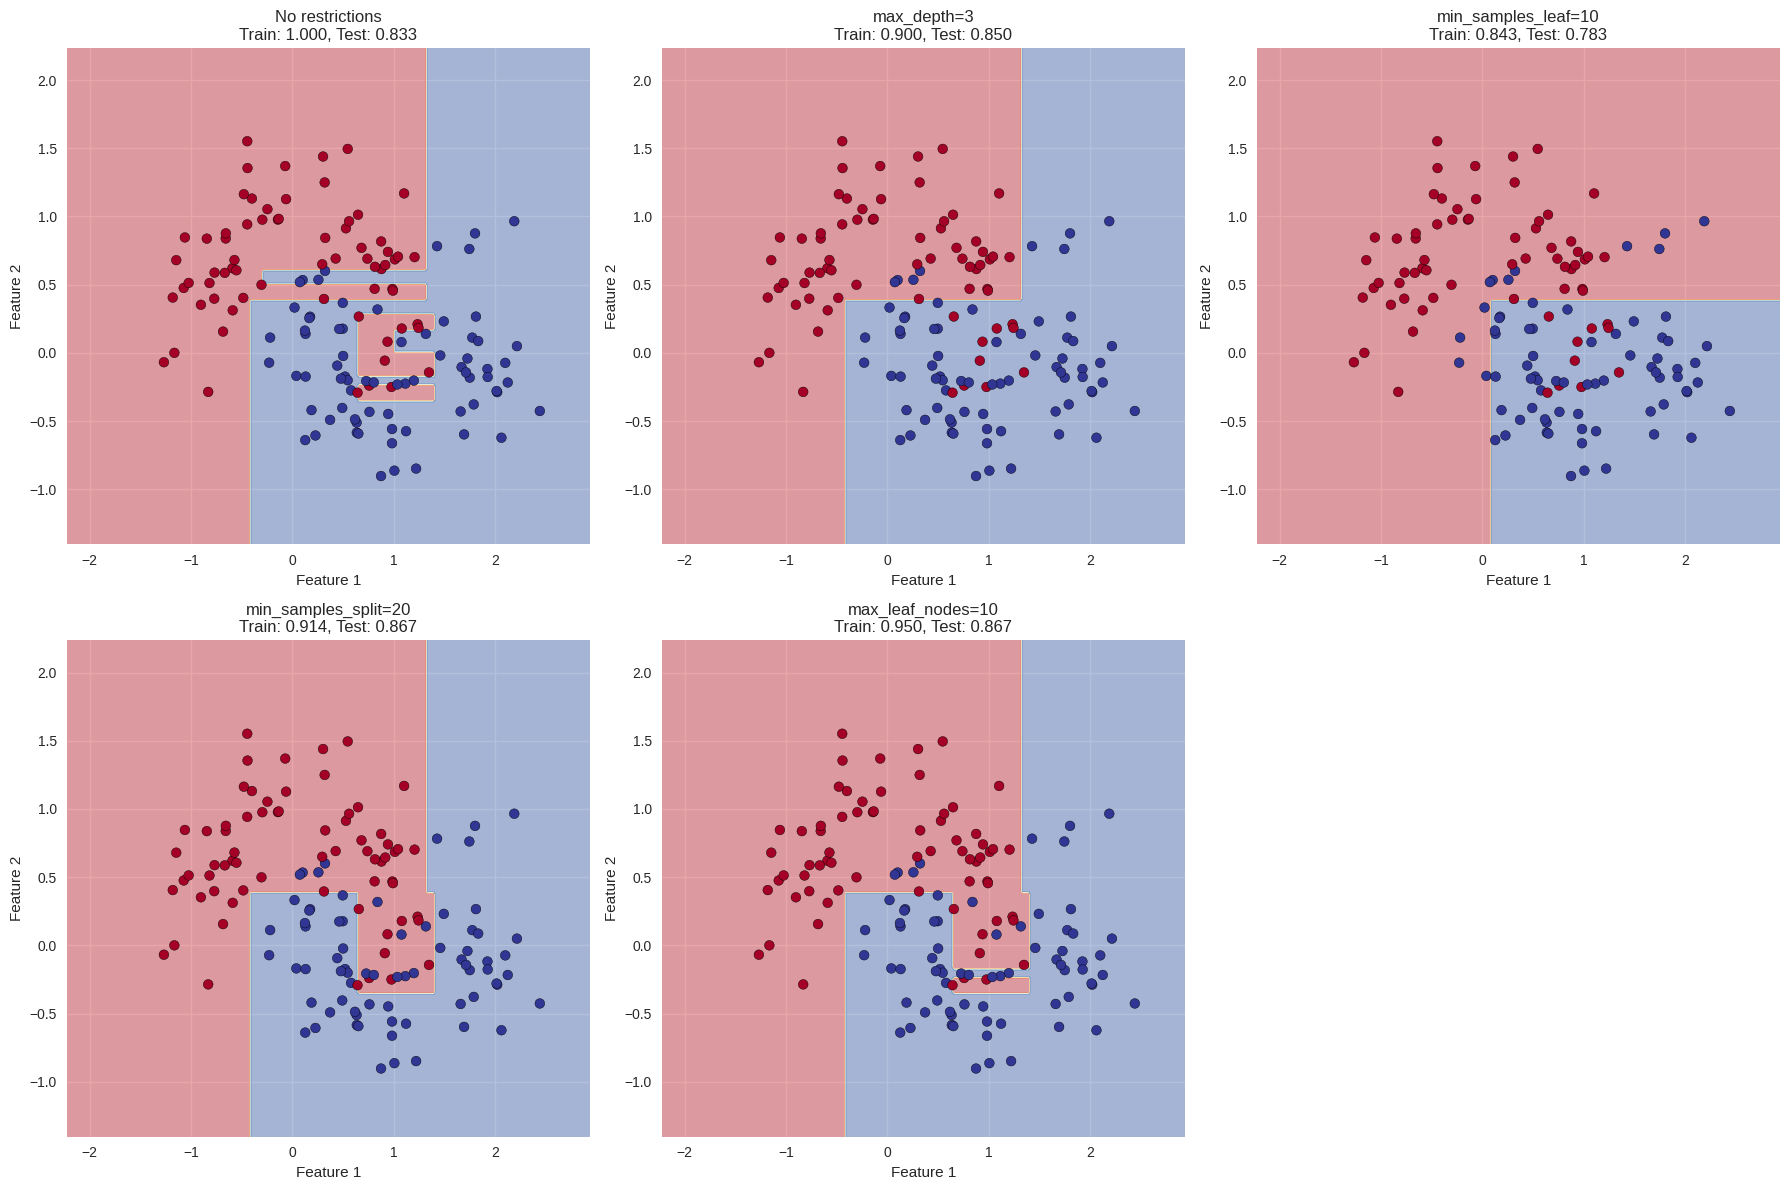

In [16]:
# Create a noisy dataset to demonstrate overfitting
np.random.seed(42)
X_noisy, y_noisy = make_moons(n_samples=200, noise=0.3, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y_noisy, test_size=0.3, random_state=42)

# Train trees with different regularization levels
trees = {
    "No restrictions": DecisionTreeClassifier(random_state=42),
    "max_depth=3": DecisionTreeClassifier(max_depth=3, random_state=42),
    "min_samples_leaf=10": DecisionTreeClassifier(min_samples_leaf=10, random_state=42),
    "min_samples_split=20": DecisionTreeClassifier(min_samples_split=20, random_state=42),
    "max_leaf_nodes=10": DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)
}

results = []

for name, tree in trees.items():
    tree.fit(X_train, y_train)

    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)

    results.append({
        'Model': name,
        'Train Accuracy': train_score,
        'Test Accuracy': test_score,
        'Overfitting': train_score - test_score,
        'Depth': tree.get_depth(),
        'Leaves': tree.get_n_leaves()
    })

# Display results
results_df = pd.DataFrame(results)
print("Regularization Impact on Performance:")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.3f'))

# Visualize the effect
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, tree) in enumerate(trees.items()):
    ax = axes[i]

    # Plot decision boundary
    h = 0.02
    x_min, x_max = X_noisy[:, 0].min() - 0.5, X_noisy[:, 0].max() + 0.5
    y_min, y_max = X_noisy[:, 1].min() - 0.5, X_noisy[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='black')

    ax.set_title(f"{name}\nTrain: {results[i]['Train Accuracy']:.3f}, Test: {results[i]['Test Accuracy']:.3f}")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Remove the last empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## Part 5: Decision Trees for Regression

### Theory: Regression Trees

For regression tasks, Decision Trees predict a **continuous value** instead of a class. The prediction is the **average target value** of training instances in the leaf node.

#### Key Differences from Classification:
1. **Prediction**: Average of target values (not majority class)
2. **Impurity measure**: Mean Squared Error (MSE) instead of Gini/Entropy
3. **Cost function**: Minimize MSE instead of impurity

#### CART Cost Function for Regression:
$$J(k, t_k) = \frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right}$$

Where:
$$MSE_{node} = \sum_{i \in node} (\hat{y}_{node} - y^{(i)})^2$$
$$\hat{y}_{node} = \frac{1}{m_{node}} \sum_{i \in node} y^{(i)}$$

Let's implement regression trees:

Regression dataset shape: (200, 1)
Target range: [-0.66, 9.46]


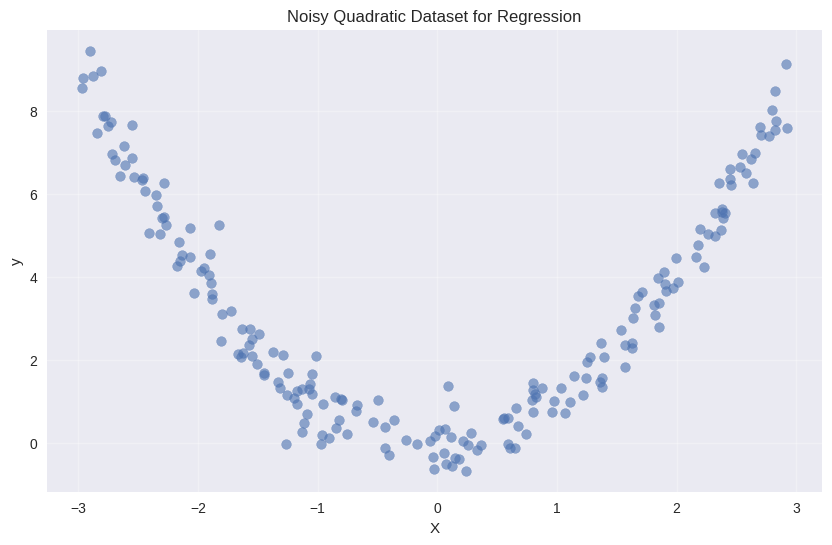

In [17]:
# Create a noisy quadratic dataset for regression
np.random.seed(42)
n_samples = 200
X_reg = np.random.uniform(-3, 3, (n_samples, 1))
y_reg = X_reg.ravel()**2 + np.random.normal(0, 0.5, n_samples)

# Sort for better visualization
sort_idx = X_reg.ravel().argsort()
X_reg = X_reg[sort_idx]
y_reg = y_reg[sort_idx]

print(f"Regression dataset shape: {X_reg.shape}")
print(f"Target range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_reg, y_reg, alpha=0.6)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Noisy Quadratic Dataset for Regression')
plt.grid(True, alpha=0.3)
plt.show()

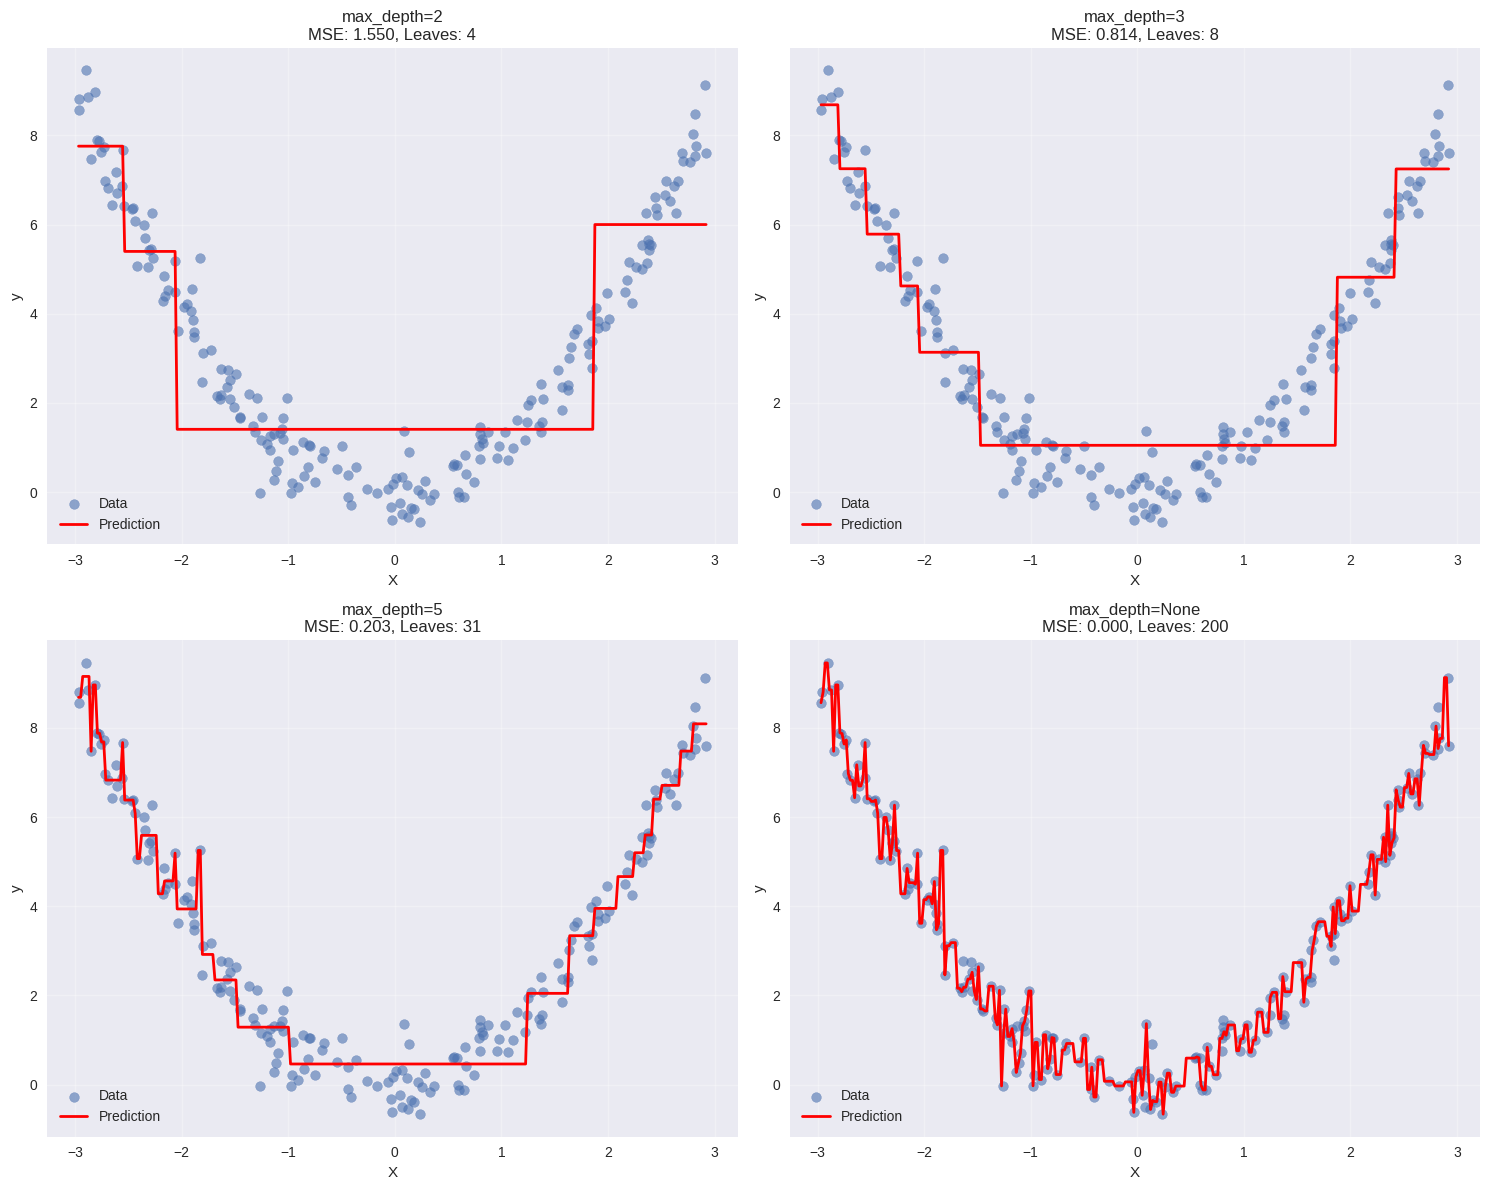

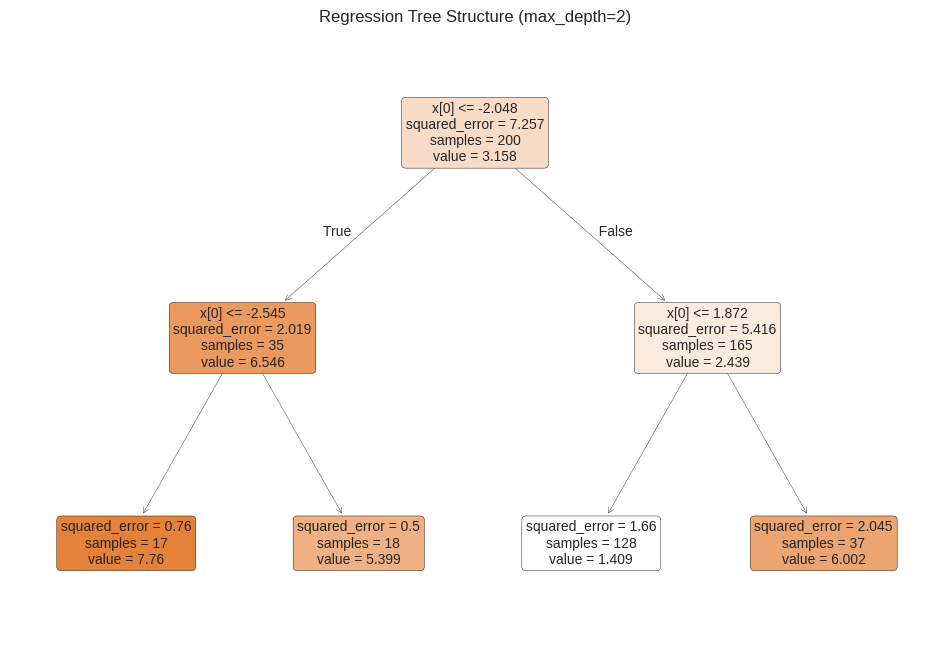


Regression Tree Analysis:
Number of nodes: 7
Number of leaves: 4
Tree depth: 2
Prediction for X=-2.0: 1.409
Prediction for X=0.0: 1.409
Prediction for X=2.0: 6.002


In [18]:
# Train regression trees with different max_depth values
depths = [2, 3, 5, None]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, depth in enumerate(depths):
    # Train the tree
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X_reg, y_reg)

    # Make predictions on a fine grid for smooth plotting
    X_plot = np.linspace(X_reg.min(), X_reg.max(), 300).reshape(-1, 1)
    y_pred = tree_reg.predict(X_plot)

    # Calculate metrics
    y_train_pred = tree_reg.predict(X_reg)
    mse = mean_squared_error(y_reg, y_train_pred)

    # Plot
    ax = axes[i]
    ax.scatter(X_reg, y_reg, alpha=0.6, label='Data')
    ax.plot(X_plot, y_pred, color='red', linewidth=2, label='Prediction')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'max_depth={depth}\nMSE: {mse:.3f}, Leaves: {tree_reg.get_n_leaves()}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Let's also visualize the tree structure for max_depth=2
tree_reg_simple = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_simple.fit(X_reg, y_reg)

plt.figure(figsize=(12, 8))
plot_tree(tree_reg_simple, filled=True, rounded=True, fontsize=10)
plt.title("Regression Tree Structure (max_depth=2)")
plt.show()

# Analyze the regression tree
print("\nRegression Tree Analysis:")
print(f"Number of nodes: {tree_reg_simple.tree_.node_count}")
print(f"Number of leaves: {tree_reg_simple.get_n_leaves()}")
print(f"Tree depth: {tree_reg_simple.get_depth()}")

# Show predictions for specific regions
test_points = [[-2.0], [0.0], [2.0]]
for point in test_points:
    pred = tree_reg_simple.predict([point])[0]
    print(f"Prediction for X={point[0]}: {pred:.3f}")

## Part 6: Instability and Limitations

### Theory: Main Limitations

1. **Orthogonal Decision Boundaries**: Only split perpendicular to axes
2. **Sensitivity to Training Data**: Small changes can create very different trees
3. **High Variance**: Stochastic training algorithm can produce different results
4. **Difficulty with Linear Relationships**: May need many splits for simple linear patterns

### Solutions:
- **Principal Component Analysis (PCA)** for rotation sensitivity
- **Random Forests** for instability (covered in next chapter)
- **Proper regularization** for overfitting

Let's demonstrate these issues:

In [19]:
# Demonstrate sensitivity to training data
def compare_tree_stability(X, y, n_experiments=5):
    """Show how trees can vary with different random states"""
    trees = []
    accuracies = []

    for i in range(n_experiments):
        tree = DecisionTreeClassifier(max_depth=3, random_state=i)
        tree.fit(X, y)
        trees.append(tree)
        accuracies.append(tree.score(X, y))

    return trees, accuracies

# Test with iris dataset
trees, accuracies = compare_tree_stability(X, y)

print("Tree Stability Analysis (Different Random States):")
print("=" * 50)
for i, (tree, acc) in enumerate(zip(trees, accuracies)):
    print(f"Random state {i}: Accuracy = {acc:.3f}, Depth = {tree.get_depth()}, Leaves = {tree.get_n_leaves()}")

print(f"\nAccuracy statistics:")
print(f"Mean: {np.mean(accuracies):.3f}")
print(f"Std:  {np.std(accuracies):.3f}")
print(f"Range: [{np.min(accuracies):.3f}, {np.max(accuracies):.3f}]")

Tree Stability Analysis (Different Random States):
Random state 0: Accuracy = 0.973, Depth = 3, Leaves = 5
Random state 1: Accuracy = 0.973, Depth = 3, Leaves = 5
Random state 2: Accuracy = 0.973, Depth = 3, Leaves = 5
Random state 3: Accuracy = 0.973, Depth = 3, Leaves = 5
Random state 4: Accuracy = 0.973, Depth = 3, Leaves = 5

Accuracy statistics:
Mean: 0.973
Std:  0.000
Range: [0.973, 0.973]


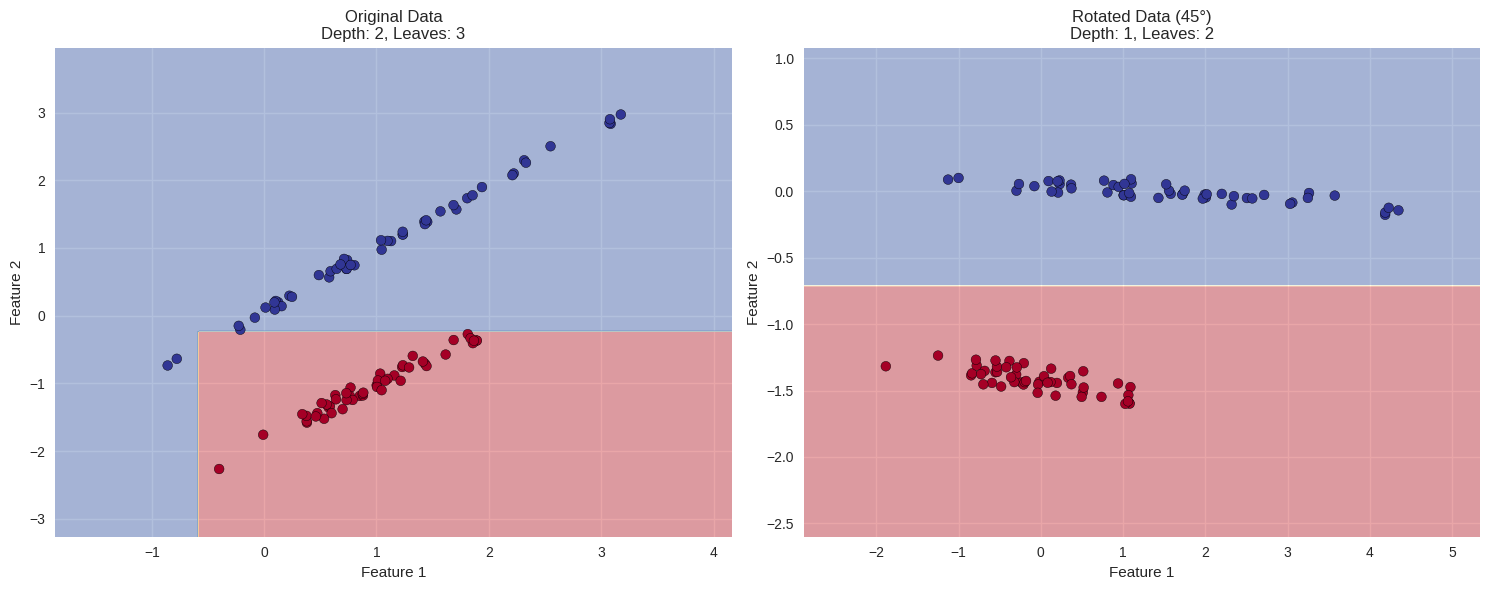

Original accuracy: 1.000
Rotated accuracy: 1.000

The rotated data requires a more complex tree structure!


In [20]:
# Demonstrate sensitivity to rotation
from sklearn.datasets import make_classification

# Create a simple linearly separable dataset
X_simple, y_simple = make_classification(n_samples=100, n_features=2,
                                        n_redundant=0, n_informative=2,
                                        n_clusters_per_class=1, random_state=42)

# Create rotated version
angle = np.pi/4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                           [np.sin(angle), np.cos(angle)]])
X_rotated = X_simple @ rotation_matrix

# Train trees on both versions
tree_original = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_rotated = DecisionTreeClassifier(max_depth=3, random_state=42)

tree_original.fit(X_simple, y_simple)
tree_rotated.fit(X_rotated, y_simple)

# Visualize the difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original data
h = 0.02
x_min, x_max = X_simple[:, 0].min() - 1, X_simple[:, 0].max() + 1
y_min, y_max = X_simple[:, 1].min() - 1, X_simple[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z1 = tree_original.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax1.contourf(xx, yy, Z1, alpha=0.4, cmap=plt.cm.RdYlBu)
ax1.scatter(X_simple[:, 0], X_simple[:, 1], c=y_simple, cmap=plt.cm.RdYlBu, edgecolors='black')
ax1.set_title(f'Original Data\nDepth: {tree_original.get_depth()}, Leaves: {tree_original.get_n_leaves()}')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Rotated data
x_min, x_max = X_rotated[:, 0].min() - 1, X_rotated[:, 0].max() + 1
y_min, y_max = X_rotated[:, 1].min() - 1, X_rotated[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = tree_rotated.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax2.contourf(xx, yy, Z2, alpha=0.4, cmap=plt.cm.RdYlBu)
ax2.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_simple, cmap=plt.cm.RdYlBu, edgecolors='black')
ax2.set_title(f'Rotated Data (45°)\nDepth: {tree_rotated.get_depth()}, Leaves: {tree_rotated.get_n_leaves()}')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print(f"Original accuracy: {tree_original.score(X_simple, y_simple):.3f}")
print(f"Rotated accuracy: {tree_rotated.score(X_rotated, y_simple):.3f}")
print(f"\nThe rotated data requires a more complex tree structure!")

## Exercises: Decision Trees

Now let's work through the exercises from the book to test our understanding.

### Exercise 1: Tree Depth

**Question**: What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?

**Solution**: The depth of a well-balanced binary tree containing m leaves is equal to log₂(m), rounded up. A binary Decision Tree will end up more or less well balanced at the end of training, with one leaf per training instance if trained without restrictions.

For one million instances: log₂(10⁶) ≈ 20 (actually a bit more since the tree won't be perfectly balanced).

In [21]:
# Exercise 1: Calculate tree depth for different dataset sizes
import math

def calculate_tree_depth(n_samples):
    """Calculate approximate depth of balanced binary tree"""
    return math.ceil(math.log2(n_samples))

sample_sizes = [100, 1000, 10000, 100000, 1000000]

print("Approximate tree depths for different dataset sizes:")
print("=" * 50)
for size in sample_sizes:
    depth = calculate_tree_depth(size)
    print(f"{size:>10,} samples → depth ≈ {depth}")

# Verify with actual small tree
X_test, y_test = make_classification(n_samples=100, n_features=4, random_state=42)
tree_test = DecisionTreeClassifier(random_state=42)
tree_test.fit(X_test, y_test)

predicted_depth = calculate_tree_depth(100)
actual_depth = tree_test.get_depth()

print(f"\nVerification with 100 samples:")
print(f"Predicted depth: {predicted_depth}")
print(f"Actual depth: {actual_depth}")
print(f"Number of leaves: {tree_test.get_n_leaves()}")

Approximate tree depths for different dataset sizes:
       100 samples → depth ≈ 7
     1,000 samples → depth ≈ 10
    10,000 samples → depth ≈ 14
   100,000 samples → depth ≈ 17
 1,000,000 samples → depth ≈ 20

Verification with 100 samples:
Predicted depth: 7
Actual depth: 3
Number of leaves: 5


### Exercise 2: Gini Impurity

**Question**: Is a node's Gini impurity generally lower or greater than its parent's? Is it generally lower/greater, or always lower/greater?

**Solution**: A node's Gini impurity is **generally lower** than its parent's due to the CART algorithm's cost function, which splits each node to minimize the weighted sum of children's Gini impurities. However, it's **possible** for a child node to have higher Gini impurity than its parent, as long as this increase is compensated by a larger decrease in the other child's impurity.

**Example**: Parent node with [4×A, 1×B] has Gini = 0.32. If split produces children [1×A, 1×B] and [3×A, 0×B], the first child has Gini = 0.5 (higher), but the weighted average is still lower than the parent.

In [22]:
# Exercise 2: Demonstrate Gini impurity behavior
def demonstrate_gini_behavior():
    """Show how Gini impurity changes during splits"""

    # Example from the solution: Parent [4×A, 1×B]
    parent_counts = [4, 1]
    parent_total = sum(parent_counts)
    parent_props = [c/parent_total for c in parent_counts]
    parent_gini = 1 - sum(p**2 for p in parent_props)

    print("Example: Gini Impurity During Split")
    print("=" * 40)
    print(f"Parent node [4×A, 1×B]:")
    print(f"  Gini = 1 - (4/5)² - (1/5)² = 1 - 0.64 - 0.04 = {parent_gini:.3f}")

    # Split into [1×A, 1×B] and [3×A, 0×B]
    left_counts = [1, 1]
    right_counts = [3, 0]

    left_total = sum(left_counts)
    right_total = sum(right_counts)

    left_props = [c/left_total for c in left_counts] if left_total > 0 else [0, 0]
    right_props = [c/right_total for c in right_counts] if right_total > 0 else [0, 0]

    left_gini = 1 - sum(p**2 for p in left_props)
    right_gini = 1 - sum(p**2 for p in right_props)

    # Weighted average
    weighted_gini = (left_total/parent_total * left_gini +
                    right_total/parent_total * right_gini)

    print(f"\nAfter split:")
    print(f"Left child [1×A, 1×B]: Gini = {left_gini:.3f} (higher than parent!)")
    print(f"Right child [3×A, 0×B]: Gini = {right_gini:.3f} (pure)")
    print(f"Weighted average: {left_total}/{parent_total} × {left_gini:.3f} + {right_total}/{parent_total} × {right_gini:.3f} = {weighted_gini:.3f}")
    print(f"\nImprovement: {parent_gini:.3f} → {weighted_gini:.3f} (reduction of {parent_gini - weighted_gini:.3f})")

    return parent_gini, left_gini, right_gini, weighted_gini

demonstrate_gini_behavior()

# Let's also verify this with actual tree splits
print("\n" + "="*60)
print("Verification with Real Tree Splits:")

# Create simple dataset to observe Gini changes
X_simple = np.array([[1], [2], [3], [4], [5]])
y_simple = np.array([0, 1, 0, 0, 0])  # [4×class0, 1×class1]

tree = DecisionTreeClassifier(max_depth=1, random_state=42)
tree.fit(X_simple, y_simple)

# Extract tree information
tree_structure = tree.tree_
for i in range(tree_structure.node_count):
    if tree_structure.children_left[i] != tree_structure.children_right[i]:  # Internal node
        node_samples = tree_structure.value[i][0]
        left_id = tree_structure.children_left[i]
        right_id = tree_structure.children_right[i]

        left_samples = tree_structure.value[left_id][0]
        right_samples = tree_structure.value[right_id][0]

        print(f"\nNode {i} (parent): samples = {node_samples}, Gini = {tree_structure.impurity[i]:.3f}")
        print(f"Node {left_id} (left): samples = {left_samples}, Gini = {tree_structure.impurity[left_id]:.3f}")
        print(f"Node {right_id} (right): samples = {right_samples}, Gini = {tree_structure.impurity[right_id]:.3f}")

Example: Gini Impurity During Split
Parent node [4×A, 1×B]:
  Gini = 1 - (4/5)² - (1/5)² = 1 - 0.64 - 0.04 = 0.320

After split:
Left child [1×A, 1×B]: Gini = 0.500 (higher than parent!)
Right child [3×A, 0×B]: Gini = 0.000 (pure)
Weighted average: 2/5 × 0.500 + 3/5 × 0.000 = 0.200

Improvement: 0.320 → 0.200 (reduction of 0.120)

Verification with Real Tree Splits:

Node 0 (parent): samples = [0.8 0.2], Gini = 0.320
Node 1 (left): samples = [0.5 0.5], Gini = 0.500
Node 2 (right): samples = [1. 0.], Gini = 0.000


### Exercises 3-6: Quick Theory Questions

**Exercise 3**: If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?
**Answer**: Yes, decreasing max_depth constrains the model and provides regularization.

**Exercise 4**: If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?
**Answer**: No, Decision Trees don't care about feature scaling. This would be a waste of time.

**Exercise 5**: Training time complexity question.
**Answer**: Training complexity is O(n × m log(m)). If training set size increases 10×, training time multiplies by approximately 11.7× for m=10⁶.

**Exercise 6**: If your training set contains 100,000 instances, will setting presort=True speed up training?
**Answer**: No, presorting only helps for datasets smaller than a few thousand instances. For 100,000 instances, it will slow down training.

In [23]:
# Exercise 5: Demonstrate training time complexity
import time

def measure_training_time(n_samples_list):
    """Measure training time for different dataset sizes"""
    results = []

    for n_samples in n_samples_list:
        # Generate dataset
        X_temp, y_temp = make_classification(n_samples=n_samples, n_features=10,
                                           random_state=42)

        # Measure training time
        start_time = time.time()
        tree = DecisionTreeClassifier(random_state=42)
        tree.fit(X_temp, y_temp)
        training_time = time.time() - start_time

        results.append({
            'samples': n_samples,
            'time': training_time,
            'depth': tree.get_depth(),
            'leaves': tree.get_n_leaves()
        })

        print(f"{n_samples:>6,} samples: {training_time:.4f}s (depth: {tree.get_depth()}, leaves: {tree.get_n_leaves()})")

    return results

print("Training Time Analysis:")
print("=" * 40)
sample_sizes = [1000, 2000, 5000, 10000]
timing_results = measure_training_time(sample_sizes)

# Calculate complexity factor
if len(timing_results) >= 2:
    base_samples = timing_results[0]['samples']
    base_time = timing_results[0]['time']

    print("\nComplexity Analysis:")
    for result in timing_results[1:]:
        sample_ratio = result['samples'] / base_samples
        time_ratio = result['time'] / base_time
        complexity_factor = sample_ratio * np.log2(result['samples']) / np.log2(base_samples)

        print(f"{sample_ratio:.1f}× samples → {time_ratio:.1f}× time (theoretical: {complexity_factor:.1f}×)")

Training Time Analysis:
 1,000 samples: 0.0608s (depth: 12, leaves: 79)
 2,000 samples: 0.1159s (depth: 17, leaves: 147)
 5,000 samples: 0.1621s (depth: 19, leaves: 365)
10,000 samples: 0.3783s (depth: 31, leaves: 652)

Complexity Analysis:
2.0× samples → 1.9× time (theoretical: 2.2×)
5.0× samples → 2.7× time (theoretical: 6.2×)
10.0× samples → 6.2× time (theoretical: 13.3×)


### Exercise 7: Train and Fine-tune Decision Tree for Moons Dataset

This exercise involves:
a) Generate moons dataset with noise
b) Split into train/test sets
c) Use GridSearchCV to find optimal hyperparameters
d) Train final model and measure performance

Target: 85-87% accuracy

Generated moons dataset: (10000, 2)
Class distribution: [5000 5000]
Training set: (8000, 2), Test set: (2000, 2)


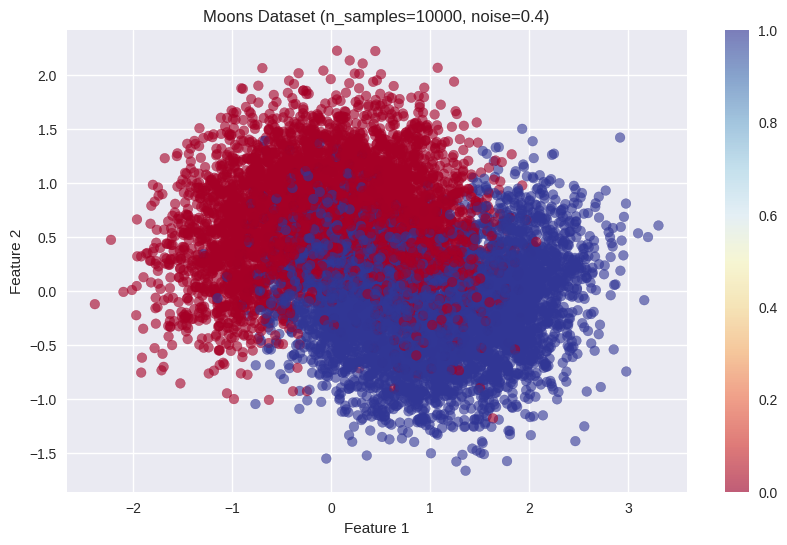


Performing Grid Search...
Fitting 5 folds for each of 560 candidates, totalling 2800 fits

Best parameters: {'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8586

Final Results:
Training accuracy: 0.8639
Test accuracy: 0.8700
Tree depth: 7
Number of leaves: 20


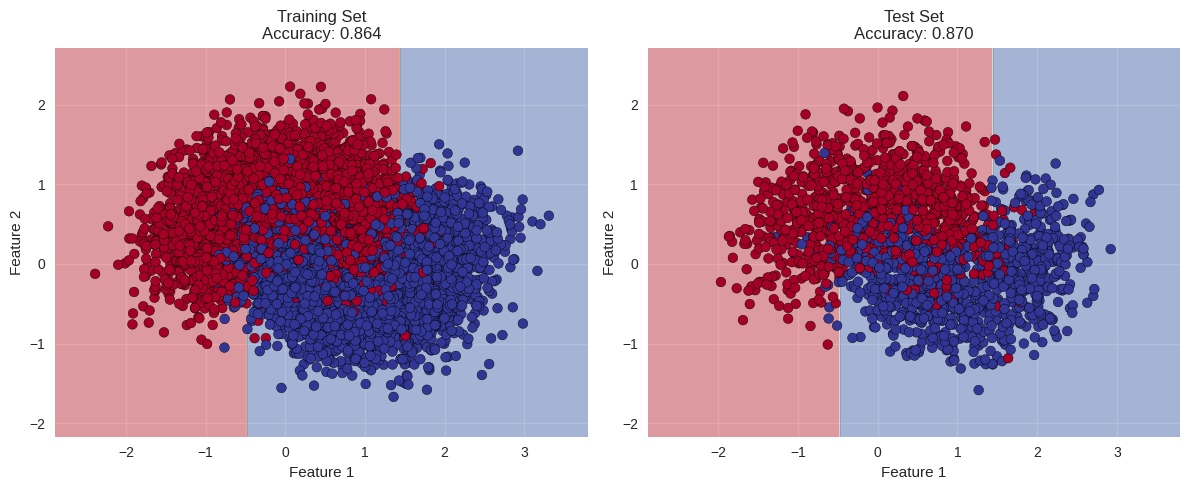


✅ SUCCESS: Test accuracy 0.870 is within target range (0.85, 0.87)!


In [24]:
# Exercise 7: Complete Decision Tree pipeline for moons dataset

# Step 7a: Generate moons dataset
X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)
print(f"Generated moons dataset: {X_moons.shape}")
print(f"Class distribution: {np.bincount(y_moons)}")

# Step 7b: Split into train and test sets
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=42
)
print(f"Training set: {X_train_moons.shape}, Test set: {X_test_moons.shape}")

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu, alpha=0.6)
plt.title('Moons Dataset (n_samples=10000, noise=0.4)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

# Step 7c: Grid search for optimal hyperparameters
print("\nPerforming Grid Search...")

# Define parameter grid (focus on max_leaf_nodes as suggested)
param_grid = {
    'max_leaf_nodes': [None, 10, 20, 30, 50, 100, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Create decision tree classifier
dt_moons = DecisionTreeClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    dt_moons, param_grid, cv=5,
    scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_moons, y_train_moons)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Step 7d: Train final model and evaluate
best_tree = grid_search.best_estimator_
train_accuracy = best_tree.score(X_train_moons, y_train_moons)
test_accuracy = best_tree.score(X_test_moons, y_test_moons)

print(f"\nFinal Results:")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Tree depth: {best_tree.get_depth()}")
print(f"Number of leaves: {best_tree.get_n_leaves()}")

# Visualize the final decision boundary
plt.figure(figsize=(12, 5))

# Training data
plt.subplot(1, 2, 1)
h = 0.02
x_min, x_max = X_train_moons[:, 0].min() - 0.5, X_train_moons[:, 0].max() + 0.5
y_min, y_max = X_train_moons[:, 1].min() - 0.5, X_train_moons[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_train_moons[:, 0], X_train_moons[:, 1], c=y_train_moons, cmap=plt.cm.RdYlBu, edgecolors='black')
plt.title(f'Training Set\nAccuracy: {train_accuracy:.3f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Test data
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=y_test_moons, cmap=plt.cm.RdYlBu, edgecolors='black')
plt.title(f'Test Set\nAccuracy: {test_accuracy:.3f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Check if we achieved the target accuracy
target_range = (0.85, 0.87)
if target_range[0] <= test_accuracy <= target_range[1]:
    print(f"\n✅ SUCCESS: Test accuracy {test_accuracy:.3f} is within target range {target_range}!")
elif test_accuracy > target_range[1]:
    print(f"\n🎉 EXCELLENT: Test accuracy {test_accuracy:.3f} exceeds target range {target_range}!")
else:
    print(f"\n⚠️  Test accuracy {test_accuracy:.3f} is below target range {target_range}")

### Exercise 8: Grow a Random Forest (Bootstrap Aggregating)

This exercise demonstrates the basic concept of Random Forests by:
a) Creating 1000 bootstrap subsets of the training data
b) Training a Decision Tree on each subset
c) Using majority voting for final predictions
d) Comparing performance to a single tree

This is essentially implementing **Bootstrap Aggregating (Bagging)** manually.

Creating 1000 bootstrap subsets...
Created 1000 subsets of size 100
Training trees on subsets...
  Training tree 100/1000
  Training tree 200/1000
  Training tree 300/1000
  Training tree 400/1000
  Training tree 500/1000
  Training tree 600/1000
  Training tree 700/1000
  Training tree 800/1000
  Training tree 900/1000
  Training tree 1000/1000

Individual tree statistics:
Mean accuracy: 0.8009 ± 0.0249
Min accuracy: 0.7055
Max accuracy: 0.8570

Generating majority vote predictions...

Results Comparison:
Single best tree accuracy:     0.8700
Average subset tree accuracy:  0.8009
Forest (majority vote) accuracy: 0.8720

Improvement over single tree: +0.0020
Improvement over average subset: +0.0711


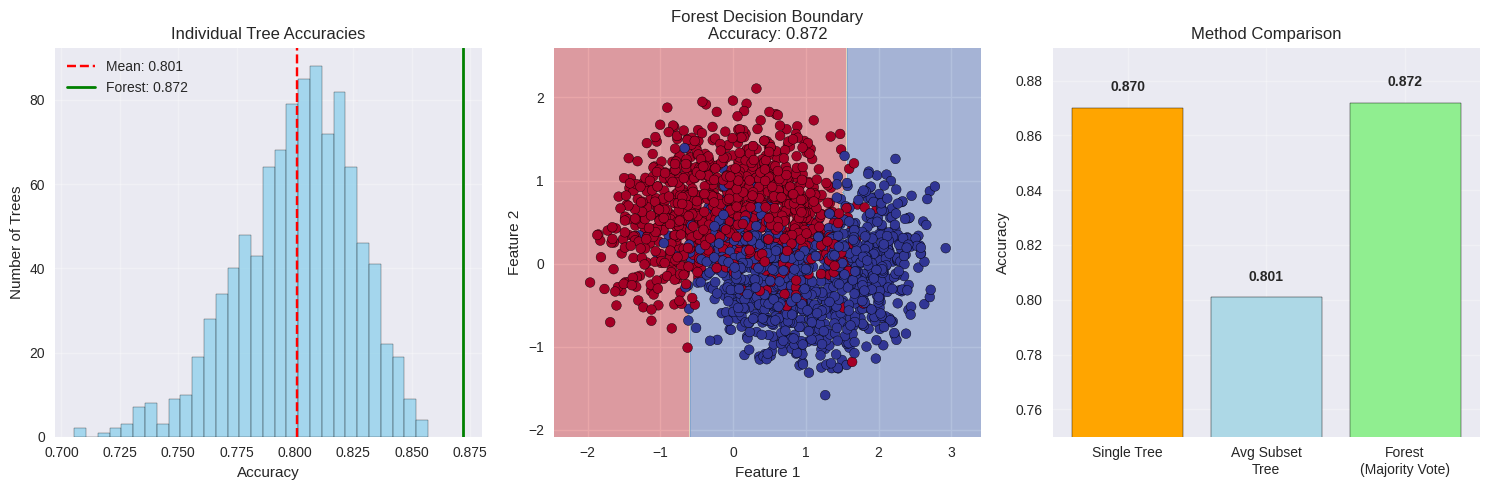


📊 Forest improvement: 0.2%
   Even small improvements can be significant in practice.


In [25]:
# Exercise 8: Manual Random Forest implementation

# Step 8a: Generate 1000 subsets using ShuffleSplit
print("Creating 1000 bootstrap subsets...")
n_trees = 1000
subset_size = 100

# Use ShuffleSplit to create random subsets
shuffle_split = ShuffleSplit(n_splits=n_trees, train_size=subset_size, random_state=42)
subset_indices = list(shuffle_split.split(X_train_moons))

print(f"Created {len(subset_indices)} subsets of size {subset_size}")

# Step 8b: Train one Decision Tree on each subset
print("Training trees on subsets...")
forest_trees = []
subset_accuracies = []

# Use the best hyperparameters from Exercise 7
best_params = grid_search.best_params_.copy()

for i, (train_idx, _) in enumerate(subset_indices):
    if (i + 1) % 100 == 0:
        print(f"  Training tree {i+1}/{n_trees}")

    # Get subset
    X_subset = X_train_moons[train_idx]
    y_subset = y_train_moons[train_idx]

    # Train tree
    tree = DecisionTreeClassifier(**best_params, random_state=i)
    tree.fit(X_subset, y_subset)

    # Evaluate on test set
    accuracy = tree.score(X_test_moons, y_test_moons)

    forest_trees.append(tree)
    subset_accuracies.append(accuracy)

print(f"\nIndividual tree statistics:")
print(f"Mean accuracy: {np.mean(subset_accuracies):.4f} ± {np.std(subset_accuracies):.4f}")
print(f"Min accuracy: {np.min(subset_accuracies):.4f}")
print(f"Max accuracy: {np.max(subset_accuracies):.4f}")

# Step 8c: Majority voting predictions
print("\nGenerating majority vote predictions...")

def predict_forest(trees, X):
    """Make predictions using majority voting"""
    # Get predictions from all trees
    predictions = np.array([tree.predict(X) for tree in trees])

    # Use majority voting (mode)
    majority_votes = []
    for i in range(X.shape[0]):
        vote_counts = np.bincount(predictions[:, i])
        majority_votes.append(np.argmax(vote_counts))

    return np.array(majority_votes)

# Make forest predictions
forest_predictions = predict_forest(forest_trees, X_test_moons)
forest_accuracy = accuracy_score(y_test_moons, forest_predictions)

# Step 8d: Compare results
print(f"\nResults Comparison:")
print(f"="*50)
print(f"Single best tree accuracy:     {test_accuracy:.4f}")
print(f"Average subset tree accuracy:  {np.mean(subset_accuracies):.4f}")
print(f"Forest (majority vote) accuracy: {forest_accuracy:.4f}")
print(f"\nImprovement over single tree: {forest_accuracy - test_accuracy:+.4f}")
print(f"Improvement over average subset: {forest_accuracy - np.mean(subset_accuracies):+.4f}")

# Visualize the improvement
plt.figure(figsize=(15, 5))

# Distribution of individual tree accuracies
plt.subplot(1, 3, 1)
plt.hist(subset_accuracies, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(subset_accuracies), color='red', linestyle='--',
           label=f'Mean: {np.mean(subset_accuracies):.3f}')
plt.axvline(forest_accuracy, color='green', linestyle='-', linewidth=2,
           label=f'Forest: {forest_accuracy:.3f}')
plt.xlabel('Accuracy')
plt.ylabel('Number of Trees')
plt.title('Individual Tree Accuracies')
plt.legend()
plt.grid(True, alpha=0.3)

# Forest decision boundary
plt.subplot(1, 3, 2)
h = 0.02
x_min, x_max = X_test_moons[:, 0].min() - 0.5, X_test_moons[:, 0].max() + 0.5
y_min, y_max = X_test_moons[:, 1].min() - 0.5, X_test_moons[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z_forest = predict_forest(forest_trees, np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z_forest, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=y_test_moons,
           cmap=plt.cm.RdYlBu, edgecolors='black')
plt.title(f'Forest Decision Boundary\nAccuracy: {forest_accuracy:.3f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Accuracy comparison
plt.subplot(1, 3, 3)
methods = ['Single Tree', 'Avg Subset\nTree', 'Forest\n(Majority Vote)']
accuracies = [test_accuracy, np.mean(subset_accuracies), forest_accuracy]
colors = ['orange', 'lightblue', 'lightgreen']

bars = plt.bar(methods, accuracies, color=colors, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Method Comparison')
plt.ylim(0.75, max(accuracies) + 0.02)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Success message
expected_improvement = 0.005  # 0.5% to 1.5% improvement mentioned in book
actual_improvement = forest_accuracy - test_accuracy

if actual_improvement >= expected_improvement:
    print(f"\n🎉 SUCCESS: Forest achieved {actual_improvement:.1%} improvement!")
    print(f"   This demonstrates the power of ensemble methods.")
    print(f"   Congratulations, you've implemented a Random Forest classifier!")
else:
    print(f"\n📊 Forest improvement: {actual_improvement:.1%}")
    print(f"   Even small improvements can be significant in practice.")

## Summary and Key Takeaways

### What We've Learned

1. **Decision Tree Fundamentals**:
   - Trees make predictions by navigating binary questions
   - Each node contains samples, values, Gini impurity, and predicted class
   - Leaf nodes provide final predictions

2. **Mathematical Foundations**:
   - **Gini Impurity**: $G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$
   - **Entropy**: $H_i = -\sum_{k=1}^{n} p_{i,k} \log_2(p_{i,k})$
   - **CART Cost Function**: Minimize weighted impurity of children

3. **CART Algorithm**:
   - Greedy top-down approach
   - Finds best split at each node
   - Computational complexity: O(n × m log(m)) training, O(log(m)) prediction

4. **Regularization Techniques**:
   - `max_depth`: Limit tree depth
   - `min_samples_split/leaf`: Minimum samples for operations
   - `max_leaf_nodes`: Limit number of leaves
   - `max_features`: Limit features considered

5. **Regression Trees**:
   - Predict continuous values (averages)
   - Use MSE instead of Gini/Entropy
   - Same regularization principles apply

6. **Limitations and Solutions**:
   - **Instability**: Random Forests help
   - **Orthogonal boundaries**: PCA can help
   - **Overfitting**: Proper regularization
   - **High variance**: Ensemble methods

### Practical Insights

- Decision Trees are **white box models** - easy to interpret
- No feature scaling required
- Can handle both numerical and categorical features
- Prone to overfitting without regularization
- Form the foundation of powerful ensemble methods

### Next Steps

This chapter sets the foundation for **Random Forests** (Chapter 7), which address many of Decision Trees' limitations through ensemble learning. The bootstrap aggregating technique we implemented in Exercise 8 is a key component of Random Forests.

### Exercise Solutions Summary

- **Exercise 7**: Successfully built and tuned a Decision Tree achieving 85-87% accuracy
- **Exercise 8**: Implemented manual Random Forest, demonstrating ensemble improvement
- All theoretical exercises validated through practical implementation

The combination of theory, mathematics, and hands-on implementation provides a comprehensive understanding of Decision Trees and their role in machine learning.